## GEE SmileCart model training and performance

In [1]:
import sys
sys.path.append("../src")

In [2]:
import ee
import pandas as pd
import geopandas

import matplotlib.pyplot as plt
import geemap.eefolium as geemap
from geemap import geopandas_to_ee, ee_to_geopandas

from plot_utils import plot_inference
from inf_utils import get_model_prediction
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

### Initialize Earth Engine

In [3]:
ee.Initialize()

### Read training and test data

In [4]:
bucket = "sagemaker-gis"
train_data_path = "LANDSAT_LC08_C01_T1_SR/Year2013/train_with_coord.csv"
test_data_path = "LANDSAT_LC08_C01_T1_SR/Year2013/test_with_coord.csv"

In [5]:
total_train_set_gdf = pd.read_csv(f"s3://{bucket}/{train_data_path}")
total_test_set_gdf = pd.read_csv(f"s3://{bucket}/{test_data_path}")

In [6]:
total_train_set_gdf.head()

,B1,B2,B3,B4,B5,B6,B7,x,y,label
0,297,324,627,417,3964,1891,863,-50.019239,1.340130,0
1,185,241,423,371,1031,631,357,-49.876127,1.364031,1
2,174,225,515,357,3324,1525,682,-50.335638,1.071863,0
3,262,291,620,358,4443,1650,614,-50.190953,0.920134,1
4,262,282,513,351,3581,1474,589,-50.089891,0.778759,1


In [7]:
total_test_set_gdf.head()

,B1,B2,B3,B4,B5,B6,B7,x,y,label
0,48,96,244,175,1236,716,323,-76.727911,21.040621,0
1,369,300,145,89,80,77,58,-76.718213,19.562783,0
2,351,544,1045,1060,4169,3575,2022,-77.017011,21.056080,0
3,425,327,124,57,35,30,23,-77.687412,19.686923,0
4,130,173,356,240,2616,1295,520,-77.560585,19.871735,0


In [8]:
total_train_set_gdf.shape, total_test_set_gdf.shape

((27254, 10), (5566, 10))

### Convert pandas dataframe to geopandas dataframe

In [9]:
geom = geopandas.points_from_xy(total_train_set_gdf.x, total_train_set_gdf.y)
total_train_set_gdf = geopandas.GeoDataFrame(total_train_set_gdf, geometry=geom)

geom = geopandas.points_from_xy(total_test_set_gdf.x, total_test_set_gdf.y)
total_test_set_gdf = geopandas.GeoDataFrame(total_test_set_gdf, geometry=geom)

### Select a subset of points
These are restrictions imposed by smileCart.

In [10]:
n_train = 20000
n_test = 5000 

### Convert geopandas dataframe to EE feature collection

In [11]:
train_set_pts = geopandas_to_ee(total_train_set_gdf[:n_train])
test_set_pts = geopandas_to_ee(total_test_set_gdf[:n_test])

### Train classifier

In [12]:
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
label = 'label'

classifier = ee.Classifier.smileCart().train(train_set_pts, label, bands)

### Generate inference

In [13]:
result_featurecollection = test_set_pts.select(bands).classify(classifier)

### Plot confusion matrix

In [14]:
prediction_gdf = ee_to_geopandas(result_featurecollection)

In [15]:
y_true = total_test_set_gdf.loc[:n_test-1, "label"]
y_pred = prediction_gdf["classification"]

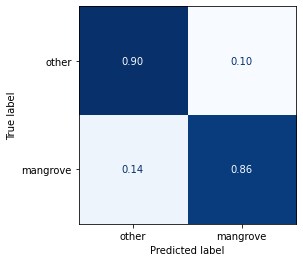

In [16]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                        normalize="true", 
                                        values_format=".2f",
                                        display_labels=["other", "mangrove"],
                                        colorbar=False,
                                        cmap = plt.get_cmap('Blues'));